In [ ]:
# STEP 1 — Clone official TimeLLM repo
!git clone https://github.com/KimMeen/Time-LLM.git
%cd Time-LLM

# Install dependencies
# (Their README lists a full set; we'll install from requirements first.)
!pip -q install -r requirements.txt

# Sanity check
!python -c "import torch; print('torch', torch.__version__, 'cuda?', torch.cuda.is_available())"

Cloning into 'Time-LLM'...
remote: Enumerating objects: 189, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 189 (delta 0), reused 0 (delta 0), pack-reused 188 (from 2)
Receiving objects: 100% (189/189), 1.09 MiB | 8.47 MiB/s, done.
Resolving deltas: 100% (92/92), done.
/content/Time-LLM
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 63.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 158.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to buil

In [ ]:
# STEP 2 (FIXED) — Robust download + unzip + load Binance 1m klines safely

import os, shutil
import pandas as pd
import requests
from zipfile import ZipFile
from dateutil.relativedelta import relativedelta

BASE = "https://data.binance.vision/data/spot/monthly/klines"
SYMBOL = "BTCUSDT"
INTERVAL = "1m"

# Clean old extracted data to avoid mixing files
shutil.rmtree("data/binance_zips", ignore_errors=True)
shutil.rmtree("data/binance_csv", ignore_errors=True)
os.makedirs("data/binance_zips", exist_ok=True)
os.makedirs("data/binance_csv", exist_ok=True)

# Choose last 3 full months (safe starter)
TODAY_UTC = pd.Timestamp.utcnow()
end_month = (TODAY_UTC.replace(day=1) - pd.Timedelta(days=1)).replace(day=1)  # last full month start
months_to_get = 3
months = [(end_month - relativedelta(months=i)).strftime("%Y-%m") for i in range(months_to_get)][::-1]
print("Target months:", months)

def download(url, out_path, chunk=1024*1024):
    r = requests.get(url, stream=True, timeout=60)
    if r.status_code != 200:
        print(f"  ! skip (status {r.status_code}): {url}")
        return False
    with open(out_path, "wb") as f:
        for part in r.iter_content(chunk_size=chunk):
            if part:
                f.write(part)
    return True

# Binance kline CSV columns (no header)
COLS = [
    "open_time","open","high","low","close","volume",
    "close_time","quote_asset_volume","num_trades",
    "taker_buy_base","taker_buy_quote","ignore"
]

def detect_time_unit(open_time_series: pd.Series) -> str:
    # Typical magnitudes: ms ~ 1e12, us ~ 1e15, ns ~ 1e18
    v = pd.to_numeric(open_time_series, errors="coerce").dropna()
    if v.empty:
        return "ms"
    med = float(v.median())
    if med > 1e17:
        return "ns"
    if med > 1e14:
        return "us"
    return "ms"

dfs = []
for ym in months:
    zip_name = f"{SYMBOL}-{INTERVAL}-{ym}.zip"
    url = f"{BASE}/{SYMBOL}/{INTERVAL}/{zip_name}"
    zip_path = os.path.join("data/binance_zips", zip_name)

    print("Downloading:", zip_name)
    if not download(url, zip_path):
        continue

    with ZipFile(zip_path, "r") as z:
        # Pick the correct CSV inside the zip (should match the zip base name)
        members = [m for m in z.namelist() if m.endswith(".csv")]
        if not members:
            print("  ! no csv inside zip:", zip_name)
            continue

        # Prefer exact match if present
        expected = f"{SYMBOL}-{INTERVAL}-{ym}.csv"
        if expected in members:
            member = expected
        else:
            # else pick the first CSV (but don't guess outside the zip)
            member = members[0]

        out_csv = os.path.join("data/binance_csv", os.path.basename(member))
        z.extract(member, "data/binance_csv")
        # If extracted with subfolders, normalize path
        extracted_path = os.path.join("data/binance_csv", member)
        if extracted_path != out_csv:
            os.makedirs(os.path.dirname(out_csv), exist_ok=True)
            shutil.move(extracted_path, out_csv)
            # clean empty dirs
            try:
                shutil.rmtree(os.path.join("data/binance_csv", os.path.dirname(member).split('/')[0]))
            except Exception:
                pass

    tmp = pd.read_csv(out_csv, header=None, names=COLS, dtype={"open_time":"int64"}, low_memory=False)

    unit = detect_time_unit(tmp["open_time"])
    tmp["open_time"] = pd.to_datetime(tmp["open_time"], unit=unit, utc=True, errors="coerce")

    # sanity filter: keep only plausible dates
    tmp = tmp.dropna(subset=["open_time"])
    now_utc = pd.Timestamp.utcnow()  # already tz-aware in recent pandas

    tmp = tmp[
       (tmp["open_time"] >= pd.Timestamp("2016-01-01", tz="UTC")) &
       (tmp["open_time"] <= now_utc + pd.Timedelta(days=2))
    ]

    # numeric conversions
    for c in ["open","high","low","close","volume"]:
        tmp[c] = pd.to_numeric(tmp[c], errors="coerce")

    tmp = tmp.dropna(subset=["close"]).copy()
    dfs.append(tmp[["open_time","open","high","low","close","volume"]])

if not dfs:
    raise RuntimeError("No data loaded. Try increasing months_to_get or verify downloads.")

raw = pd.concat(dfs, ignore_index=True)
raw = raw.sort_values("open_time").drop_duplicates("open_time").reset_index(drop=True)

print("Loaded rows:", len(raw))
print("Time range:", raw["open_time"].min(), "->", raw["open_time"].max())
raw.head()

Target months: ['2025-10', '2025-11', '2025-12']
Downloading: BTCUSDT-1m-2025-10.zip
Downloading: BTCUSDT-1m-2025-11.zip
Downloading: BTCUSDT-1m-2025-12.zip
Loaded rows: 132480
Time range: 2025-10-01 00:00:00+00:00 -> 2025-12-31 23:59:00+00:00


,open_time,open,high,low,close,volume
0,2025-10-01 00:00:00+00:00,114048.94,114100.00,114048.93,114100.00,18.30369
1,2025-10-01 00:01:00+00:00,114100.00,114222.95,114099.99,114172.00,20.65539
2,2025-10-01 00:02:00+00:00,114171.99,114182.87,114145.10,114166.99,4.25729
3,2025-10-01 00:03:00+00:00,114167.00,114176.25,114149.09,114164.48,6.49881
4,2025-10-01 00:04:00+00:00,114164.48,114211.40,114158.34,114211.40,2.88053


In [ ]:
# STEP 3 — Compute RV_fwd, RV_past, residual y, and export TimeLLM CSV

import numpy as np
import pandas as pd
import os

# raw is expected from Step 2 with columns:
# open_time (UTC tz-aware), open, high, low, close, volume
assert "open_time" in raw.columns and "close" in raw.columns, "Run Step 2 first."

H = 60  # 60 minutes = 1 hour ahead for 1m data

d = raw.copy()
d = d.sort_values("open_time").reset_index(drop=True)

# log returns
d["log_close"] = np.log(d["close"].astype(float) + 1e-12)
d["r"] = d["log_close"].diff()

r2 = d["r"].pow(2)

# Past RV over last H returns up to time t
d["RV_past"] = np.sqrt(r2.rolling(window=H).sum())

# Forward RV over next H returns (from t+1 ... t+H)
# Align so value is at time t
d["RV_fwd"] = np.sqrt(r2.shift(-1).rolling(window=H).sum())

eps = 1e-12
d["y"] = np.log(d["RV_fwd"] + eps) - np.log(d["RV_past"] + eps)

# Optional simple covariates (useful later if you want multivariate features)
d["hl_range"] = np.log((d["high"] + eps) / (d["low"] + eps))
d["co_move"]  = np.log((d["close"] + eps) / (d["open"] + eps))
d["log_vol"]  = np.log1p(d["volume"].astype(float))

# Drop rows without enough history/future
d = d.dropna(subset=["y", "RV_past", "RV_fwd", "hl_range", "co_move", "log_vol"]).reset_index(drop=True)

print("After label/features dropna:", len(d))
print("Time range:", d["open_time"].min(), "->", d["open_time"].max())

# --- Create TimeLLM-ready dataset CSV ---
# TimeLLM-style loaders typically want a `date` column and one target column.
# We'll store `y` as the target; you can optionally include covariates later.

out_dir = "data/timellm_dataset"
os.makedirs(out_dir, exist_ok=True)

timellm_df = pd.DataFrame({
    "date": d["open_time"].dt.tz_convert("UTC").dt.strftime("%Y-%m-%d %H:%M:%S"),
    "y": d["y"].astype(float),
    # keep these for later multivariate experiments (safe to include)
    "hl_range": d["hl_range"].astype(float),
    "co_move": d["co_move"].astype(float),
    "log_vol": d["log_vol"].astype(float),
})

csv_path = os.path.join(out_dir, f"{SYMBOL}_{INTERVAL}_RV1h_residual.csv")
timellm_df.to_csv(csv_path, index=False)

print("Saved:", csv_path)
timellm_df.head()

After label/features dropna: 132419
Time range: 2025-10-01 01:00:00+00:00 -> 2025-12-31 23:58:00+00:00
Saved: data/timellm_dataset/BTCUSDT_1m_RV1h_residual.csv


,date,y,hl_range,co_move,log_vol
0,2025-10-01 01:00:00,-0.025542,0.000354,-0.000354,2.109159
1,2025-10-01 01:01:00,-0.000064,0.000299,-0.000250,1.542174
2,2025-10-01 01:02:00,0.006520,0.000033,-0.000033,1.015524
3,2025-10-01 01:03:00,-0.005490,0.000499,0.000291,1.978218
4,2025-10-01 01:04:00,-0.007187,0.000392,0.000313,1.933631


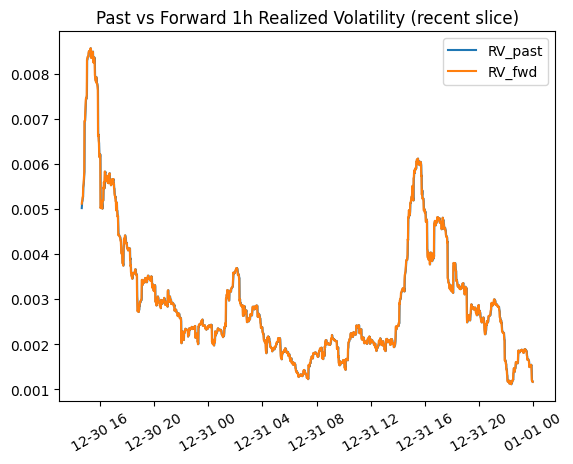

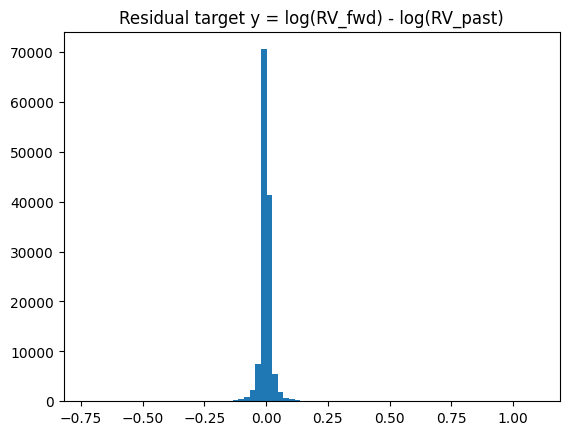

In [ ]:
import matplotlib.pyplot as plt

sample = d.iloc[-2000:].copy()

plt.figure()
plt.plot(sample["open_time"], sample["RV_past"], label="RV_past")
plt.plot(sample["open_time"], sample["RV_fwd"], label="RV_fwd")
plt.legend()
plt.title("Past vs Forward 1h Realized Volatility (recent slice)")
plt.xticks(rotation=30)
plt.show()

plt.figure()
plt.hist(d["y"].values, bins=80)
plt.title("Residual target y = log(RV_fwd) - log(RV_past)")
plt.show()

In [ ]:
# 4.0 — Upgrade HF stack (prevents checkpoint discovery bugs) + clear broken cache

!pip -q install -U transformers huggingface_hub safetensors accelerate

# Clear any partially-cached / wrong-ID model folders that can break from_pretrained
!rm -rf ~/.cache/huggingface/hub/models--GPT2*
!rm -rf ~/.cache/huggingface/hub/models--gpt2*  # optional clean slate

# Sanity check download works
from transformers import GPT2Model
_ = GPT2Model.from_pretrained("gpt2")
print("✅ HuggingFace gpt2 loads OK")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 129.1 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

✅ HuggingFace gpt2 loads OK


In [ ]:
# 4.1 — Copy your Step-3 CSV into ./dataset/BTCVOL1m/BTCVOL1m.csv (univariate: date,y)

import os, shutil, pandas as pd

src_csv = "data/timellm_dataset/BTCUSDT_1m_RV1h_residual.csv"
assert os.path.exists(src_csv), f"Missing {src_csv}. Run Step 3 first."

ds_name = "BTCVOL1m"
dst_dir = f"dataset/{ds_name}"
os.makedirs(dst_dir, exist_ok=True)

dst_csv = f"{dst_dir}/{ds_name}.csv"
shutil.copy(src_csv, dst_csv)

df = pd.read_csv(dst_csv)
df = df[["date", "y"]]  # univariate for first run
df.to_csv(dst_csv, index=False)

print("✅ Dataset saved to:", dst_csv)
print("Rows:", len(df), "| Range:", df["date"].iloc[0], "->", df["date"].iloc[-1])
df.head()

✅ Dataset saved to: dataset/BTCVOL1m/BTCVOL1m.csv
Rows: 132419 | Range: 2025-10-01 01:00:00 -> 2025-12-31 23:58:00


,date,y
0,2025-10-01 01:00:00,-0.025542
1,2025-10-01 01:01:00,-0.000064
2,2025-10-01 01:02:00,0.006520
3,2025-10-01 01:03:00,-0.005490
4,2025-10-01 01:04:00,-0.007187


In [ ]:
# 4.2 — Patch run_main.py to NOT require DeepSpeed (Accelerate will run normally)

import re, pathlib

path = pathlib.Path("run_main.py")
txt = path.read_text()

# Remove deepspeed_plugin argument if present
txt_new = re.sub(
    r"Accelerator\(([^)]*?)deepspeed_plugin\s*=\s*deepspeed_plugin\s*,?\s*([^)]*?)\)",
    r"Accelerator(\1\2)",
    txt
)

# Direct fallback replacement if regex didn't match
if txt_new == txt:
    txt_new = txt.replace(
        "accelerator = Accelerator(kwargs_handlers=[ddp_kwargs], deepspeed_plugin=deepspeed_plugin)",
        "accelerator = Accelerator(kwargs_handlers=[ddp_kwargs])"
    )

path.write_text(txt_new)
print("✅ Patched run_main.py to disable DeepSpeed requirement")

✅ Patched run_main.py to disable DeepSpeed requirement


In [ ]:
# 4.3 — Create dataset loader that matches repo call signature (accepts percent, **kwargs)

import os, textwrap, pathlib

custom_path = "data_provider/dataset_btcvol.py"
os.makedirs("data_provider", exist_ok=True)

with open(custom_path, "w") as f:
    f.write(textwrap.dedent("""
    import os
    import numpy as np
    import pandas as pd
    from torch.utils.data import Dataset

    class Dataset_BTCVOL(Dataset):
        '''
        Minimal dataset for Time-LLM.
        Expects CSV with columns: date, y

        Returns:
          seq_x: (seq_len, 1)
          seq_y: (label_len + pred_len, 1)

        Chronological split:
          70% train / 10% val / 20% test
        '''
        def __init__(self, root_path, data_path, flag='train', size=None,
                     features='S', target='y', scale=False, timeenc=0, freq='t',
                     percent=100, **kwargs):

            assert size is not None, "size must be [seq_len, label_len, pred_len]"
            self.seq_len, self.label_len, self.pred_len = size
            self.root_path = root_path
            self.data_path = data_path
            self.flag = flag
            self.target = target

            df = pd.read_csv(os.path.join(root_path, data_path))
            assert "date" in df.columns, "CSV must contain 'date'"
            assert target in df.columns, f"CSV must contain target '{target}'"

            data = df[[target]].astype(np.float32).values
            n = len(data)

            # optional percent usage on train split only
            n_train = int(n * 0.7)
            n_val = int(n * 0.1)

            train = data[:n_train]
            val   = data[n_train:n_train+n_val]
            test  = data[n_train+n_val:]

            if flag == "train":
                if percent < 100:
                    m = int(len(train) * (percent / 100.0))
                    train = train[:max(m, self.seq_len + self.pred_len + 1)]
                self.data_x = train
            elif flag == "val":
                self.data_x = val
            else:
                self.data_x = test

            self.data_y = self.data_x

        def __len__(self):
            return len(self.data_x) - self.seq_len - self.pred_len + 1

        def __getitem__(self, index):
            s_begin = index
            s_end = s_begin + self.seq_len
            r_begin = s_end - self.label_len
            r_end = s_end + self.pred_len

            seq_x = self.data_x[s_begin:s_end]
            seq_y = self.data_y[r_begin:r_end]
            return seq_x, seq_y
    """))

print("✅ Wrote dataset loader:", custom_path)

# Patch data_factory.py to import and register BTCVOL1m
factory = pathlib.Path("data_provider/data_factory.py")
txt = factory.read_text()

if "Dataset_BTCVOL" not in txt:
    txt = txt.replace(
        "from data_provider.data_loader import",
        "from data_provider.dataset_btcvol import Dataset_BTCVOL\nfrom data_provider.data_loader import"
    )

if "'BTCVOL1m'" not in txt:
    marker = "data_dict = {"
    if marker not in txt:
        raise RuntimeError("Could not find `data_dict = {` in data_factory.py")
    txt = txt.replace(marker, marker + "\n    'BTCVOL1m': Dataset_BTCVOL,")

factory.write_text(txt)
print("✅ Registered dataset key 'BTCVOL1m' in data_factory.py")

✅ Wrote dataset loader: data_provider/dataset_btcvol.py
✅ Registered dataset key 'BTCVOL1m' in data_factory.py


In [ ]:
  !python -u run_main.py \
    --task_name short_term_forecast \
    --is_training 1 \
    --model_id BTCVOL1m_TimeLLM \
    --model_comment BTC_1m_RV1h \
    --model TimeLLM \
    --data BTCVOL1m \
    --root_path ./dataset/BTCVOL1m/ \
    --data_path BTCVOL1m.csv \
    --features S \
    --target y \
    --freq t \
    --seq_len 54 \
    --label_len 18 \
    --pred_len 1 \
    --enc_in 1 \
    --dec_in 1 \
    --c_out 1 \
    --patch_len 12 \
    --stride 6 \
    --llm_model BERT \
    --llm_dim 768 \
    --llm_layers 6 \
    --batch_size 32 \
    --learning_rate 1e-4 \
    --train_epochs 5 \
    --patience 3 \
    --use_amp

2026-01-18 14:07:00.229641: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768745220.250847    8420 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768745220.257366    8420 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768745220.273629    8420 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768745220.273654    8420 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768745220.273657    8420 computation_placer.cc:177] computation placer alr

In [ ]:
# PATCH TimeLLM.py to load BERT robustly in Colab (avoid google-bert + local_files_only issues)

import pathlib, re

p = pathlib.Path("models/TimeLLM.py")
txt = p.read_text()

# Replace google-bert model id with standard HF id
txt = txt.replace("'google-bert/bert-base-uncased'", "'bert-base-uncased'")

# Force local_files_only=False (so it downloads weights properly)
txt = txt.replace("local_files_only=True", "local_files_only=False")

# trust_remote_code is not needed for bert-base-uncased (safer to disable)
txt = txt.replace("trust_remote_code=True", "trust_remote_code=False")

p.write_text(txt)
print("✅ Patched TimeLLM.py for robust BERT loading (bert-base-uncased, download enabled).")

✅ Patched TimeLLM.py for robust BERT loading (bert-base-uncased, download enabled).


In [ ]:
from transformers import BertModel, BertTokenizer
_ = BertModel.from_pretrained("bert-base-uncased")
_ = BertTokenizer.from_pretrained("bert-base-uncased")
print("✅ BERT base uncased downloads/loads OK")

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

✅ BERT base uncased downloads/loads OK


In [ ]:
# Create prompt_bank file required by TimeLLM

import os

os.makedirs("dataset/prompt_bank", exist_ok=True)

prompt_path = "dataset/prompt_bank/BTCVOL1m.txt"
prompt_text = """BTCUSDT 1-minute volatility residual forecasting.
You are given a time series y_t where:
y_t = log(RV_{t+60}) - log(RV_past_t),
RV_{t+60} is 1-hour forward realized volatility computed from 1-minute log returns,
and RV_past_t is 1-hour past realized volatility.
Given the past window, predict the next-step y value (pred_len=1).
"""

with open(prompt_path, "w") as f:
    f.write(prompt_text)

print("✅ Wrote:", prompt_path)
print(prompt_text)

✅ Wrote: dataset/prompt_bank/BTCVOL1m.txt
BTCUSDT 1-minute volatility residual forecasting.
You are given a time series y_t where:
y_t = log(RV_{t+60}) - log(RV_past_t),
RV_{t+60} is 1-hour forward realized volatility computed from 1-minute log returns,
and RV_past_t is 1-hour past realized volatility.
Given the past window, predict the next-step y value (pred_len=1).



In [ ]:
# Patch np.Inf -> np.inf for NumPy 2.0 compatibility

import pathlib

p = pathlib.Path("utils/tools.py")
txt = p.read_text()

if "np.Inf" in txt:
    txt = txt.replace("np.Inf", "np.inf")
    p.write_text(txt)
    print("✅ Patched utils/tools.py: np.Inf -> np.inf")
else:
    print("No np.Inf found (already patched).")

✅ Patched utils/tools.py: np.Inf -> np.inf


In [ ]:
# PATCH dataset_btcvol.py to return 4 values expected by training loop:
# (seq_x, seq_y, seq_x_mark, seq_y_mark)

import textwrap

custom_path = "data_provider/dataset_btcvol.py"

with open(custom_path, "w") as f:
    f.write(textwrap.dedent("""
    import os
    import numpy as np
    import pandas as pd
    from torch.utils.data import Dataset

    class Dataset_BTCVOL(Dataset):
        '''
        Custom dataset for Time-LLM training loop which expects:
          (batch_x, batch_y, batch_x_mark, batch_y_mark)

        CSV columns required: date, y
        We return dummy time-mark features (zeros) to satisfy interface.
        '''
        def __init__(self, root_path, data_path, flag='train', size=None,
                     features='S', target='y', scale=False, timeenc=0, freq='t',
                     percent=100, **kwargs):

            assert size is not None, "size must be [seq_len, label_len, pred_len]"
            self.seq_len, self.label_len, self.pred_len = size
            self.root_path = root_path
            self.data_path = data_path
            self.flag = flag
            self.target = target

            df = pd.read_csv(os.path.join(root_path, data_path))
            assert "date" in df.columns, "CSV must contain 'date'"
            assert target in df.columns, f"CSV must contain target '{target}'"

            data = df[[target]].astype(np.float32).values
            n = len(data)

            n_train = int(n * 0.7)
            n_val = int(n * 0.1)

            train = data[:n_train]
            val   = data[n_train:n_train+n_val]
            test  = data[n_train+n_val:]

            if flag == "train":
                if percent < 100:
                    m = int(len(train) * (percent / 100.0))
                    train = train[:max(m, self.seq_len + self.pred_len + 1)]
                self.data_x = train
            elif flag == "val":
                self.data_x = val
            else:
                self.data_x = test

            self.data_y = self.data_x

            # Dummy time marks (1 feature of zeros). Many repos use 4-5 time features;
            # zeros is fine for getting the pipeline running.
            self.mark_dim = 1

        def __len__(self):
            return len(self.data_x) - self.seq_len - self.pred_len + 1

        def __getitem__(self, index):
            s_begin = index
            s_end = s_begin + self.seq_len
            r_begin = s_end - self.label_len
            r_end = s_end + self.pred_len

            seq_x = self.data_x[s_begin:s_end]                       # (seq_len, 1)
            seq_y = self.data_y[r_begin:r_end]                       # (label_len+pred_len, 1)

            seq_x_mark = np.zeros((self.seq_len, self.mark_dim), dtype=np.float32)
            seq_y_mark = np.zeros((self.label_len + self.pred_len, self.mark_dim), dtype=np.float32)

            return seq_x, seq_y, seq_x_mark, seq_y_mark
    """))

print("✅ Updated dataset_btcvol.py to return 4 items (x, y, x_mark, y_mark).")

✅ Updated dataset_btcvol.py to return 4 items (x, y, x_mark, y_mark).


In [ ]:
!python -u run_main.py \
  --task_name short_term_forecast \
  --is_training 1 \
  --model_id BTCVOL1m_TimeLLM \
  --model_comment BTC_1m_RV1h \
  --model TimeLLM \
  --data BTCVOL1m \
  --root_path ./dataset/BTCVOL1m/ \
  --data_path BTCVOL1m.csv \
  --features S \
  --target y \
  --freq t \
  --seq_len 54 \
  --label_len 18 \
  --pred_len 1 \
  --enc_in 1 \
  --dec_in 1 \
  --c_out 1 \
  --patch_len 12 \
  --stride 6 \
  --llm_model BERT \
  --llm_dim 768 \
  --llm_layers 6 \
  --batch_size 16 \
  --learning_rate 1e-4 \
  --train_epochs 5 \
  --patience 3 \
  --use_amp

2026-01-18 14:11:25.818670: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768745485.839825    9770 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768745485.846256    9770 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768745485.862466    9770 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768745485.862496    9770 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768745485.862499    9770 computation_placer.cc:177] computation placer alr

In [ ]:
# Disable automatic checkpoint deletion (del_files('./checkpoints'))

import pathlib, re

p = pathlib.Path("run_main.py")
lines = p.read_text().splitlines()

new_lines = []
for line in lines:
    if re.search(r"\bdel_files\(\s*path\s*\)", line):
        new_lines.append("# " + line + "  # DISABLED: keep checkpoints")
    else:
        new_lines.append(line)

p.write_text("\n".join(new_lines))
print("✅ Patched run_main.py: del_files(path) disabled")

✅ Patched run_main.py: del_files(path) disabled


In [ ]:
!sed -n '260,285p' run_main.py

                    accelerator.print("lr = {:.10f}".format(model_optim.param_groups[0]['lr']))
                adjust_learning_rate(accelerator, model_optim, scheduler, epoch + 1, args, printout=True)

        else:
            accelerator.print('Updating learning rate to {}'.format(scheduler.get_last_lr()[0]))

accelerator.wait_for_everyone()
if accelerator.is_local_main_process:
    path = './checkpoints'  # unique checkpoint saving path
#     del_files(path)  # delete checkpoint files  # DISABLED: keep checkpoints
#     accelerator.print('success delete checkpoints')

In [ ]:
!mkdir -p checkpoints
!ls -la checkpoints

total 8
drwxr-xr-x  2 root root 4096 Jan 18 15:36 .
drwxr-xr-x 13 root root 4096 Jan 18 15:36 ..


In [ ]:
!python -u run_main.py \
  --task_name short_term_forecast \
  --is_training 1 \
  --model_id BTCVOL1m_TimeLLM \
  --model_comment BTC_1m_RV1h \
  --model TimeLLM \
  --data BTCVOL1m \
  --root_path ./dataset/BTCVOL1m/ \
  --data_path BTCVOL1m.csv \
  --features S \
  --target y \
  --freq t \
  --seq_len 54 \
  --label_len 18 \
  --pred_len 1 \
  --enc_in 1 \
  --dec_in 1 \
  --c_out 1 \
  --patch_len 12 \
  --stride 6 \
  --llm_model BERT \
  --llm_dim 768 \
  --llm_layers 6 \
  --batch_size 16 \
  --learning_rate 1e-4 \
  --train_epochs 5 \
  --patience 3 \
  --use_amp

2026-01-18 15:37:18.645843: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768750638.667304   32910 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768750638.673790   32910 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768750638.690156   32910 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768750638.690187   32910 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768750638.690190   32910 computation_placer.cc:177] computation placer alr

In [ ]:
!find checkpoints -maxdepth 3 -type f | head -n 50

checkpoints/short_term_forecast_BTCVOL1m_TimeLLM_TimeLLM_BTCVOL1m_ftS_sl54_ll18_pl1_dm16_nh8_el2_dl1_df32_fc1_ebtimeF_test_0-BTC_1m_RV1h/checkpoint


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r checkpoints /content/drive/MyDrive/TimeLLM_checkpoints_BTCVOL1m
!find /content/drive/MyDrive/TimeLLM_checkpoints_BTCVOL1m -type f | head -n 50

/content/drive/MyDrive/TimeLLM_checkpoints_BTCVOL1m/short_term_forecast_BTCVOL1m_TimeLLM_TimeLLM_BTCVOL1m_ftS_sl54_ll18_pl1_dm16_nh8_el2_dl1_df32_fc1_ebtimeF_test_0-BTC_1m_RV1h/checkpoint


Run inference/test mode to generate predictions